Downloading the Dataset

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="1TnxI6x7tidUrpzv2WBZ")
project = rf.workspace("sukhada-chandavale-vcco1").project("accidetect-bae6p")
version = project.version(4)
dataset = version.download("coco")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.1

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to AcciDetect-4 in coco:: 100%|██████████| 17641/17641 [00:09<00:00, 1825.85it/s]


In [3]:
import numpy as np
import pandas as pd
import os

In [4]:
!pip install -U torchvision #new versino of torchvision for this project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.

All the necessary libraries

In [5]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  #augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

PyCOCOTools provides many utilities for dealing with datasets in the COCO format.



In [7]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

In [8]:
from albumentations.pytorch import ToTensorV2

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [9]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Dataset

This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [10]:
class AccidentDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are required for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split 
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] #annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} #transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [11]:
dataset_path = "/content/AcciDetect-4/"

In [12]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


{0: {'id': 0, 'name': 'Accident', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'bike_bike_accident', 'supercategory': 'Accident'},
 2: {'id': 2, 'name': 'bike_object_accident', 'supercategory': 'Accident'},
 3: {'id': 3, 'name': 'bike_person_accident', 'supercategory': 'Accident'},
 4: {'id': 4, 'name': 'car_bike_accident', 'supercategory': 'Accident'},
 5: {'id': 5, 'name': 'car_car_accident', 'supercategory': 'Accident'},
 6: {'id': 6, 'name': 'car_object_accident', 'supercategory': 'Accident'},
 7: {'id': 7, 'name': 'car_person_accident', 'supercategory': 'Accident'}}

In [13]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Accident',
 'bike_bike_accident',
 'bike_object_accident',
 'bike_person_accident',
 'car_bike_accident',
 'car_car_accident',
 'car_object_accident',
 'car_person_accident']

In [ ]:
train_dataset = AccidentDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


## Model

Our model is FasterRCNN with a backbone of `MobileNetV3-Large`. We need to change the output layers because we have just 7 classes but this model was trained on 90 classes.

In [ ]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda")

In [ ]:
model = model.to(device)

Optimizer

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [ ]:
import sys

## Training

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict) #print
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

10 Epochs should be enough to train this model for a high accuracy

In [ ]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 2370/2370 [05:40<00:00,  6.97it/s]


Epoch 0, lr: 0.010000, loss: 0.685579, loss_classifier: 0.335459, loss_box: 0.324876, loss_rpn_box: 0.010260, loss_object: 0.014984


100%|██████████| 2370/2370 [05:22<00:00,  7.36it/s]


Epoch 1, lr: 0.010000, loss: 0.628253, loss_classifier: 0.278885, loss_box: 0.333195, loss_rpn_box: 0.008252, loss_object: 0.007921


100%|██████████| 2370/2370 [05:24<00:00,  7.31it/s]


Epoch 2, lr: 0.010000, loss: 0.607810, loss_classifier: 0.254147, loss_box: 0.339804, loss_rpn_box: 0.007600, loss_object: 0.006259


100%|██████████| 2370/2370 [05:20<00:00,  7.39it/s]


Epoch 3, lr: 0.010000, loss: 0.585718, loss_classifier: 0.235587, loss_box: 0.337158, loss_rpn_box: 0.007247, loss_object: 0.005726


100%|██████████| 2370/2370 [05:11<00:00,  7.61it/s]


Epoch 4, lr: 0.010000, loss: 0.557789, loss_classifier: 0.215548, loss_box: 0.330760, loss_rpn_box: 0.006736, loss_object: 0.004745


100%|██████████| 2370/2370 [05:17<00:00,  7.47it/s]


Epoch 5, lr: 0.010000, loss: 0.533836, loss_classifier: 0.200160, loss_box: 0.322958, loss_rpn_box: 0.006311, loss_object: 0.004406


100%|██████████| 2370/2370 [05:19<00:00,  7.41it/s]


Epoch 6, lr: 0.010000, loss: 0.510734, loss_classifier: 0.188441, loss_box: 0.311936, loss_rpn_box: 0.006334, loss_object: 0.004022


100%|██████████| 2370/2370 [05:12<00:00,  7.59it/s]


Epoch 7, lr: 0.010000, loss: 0.492563, loss_classifier: 0.177057, loss_box: 0.306380, loss_rpn_box: 0.005710, loss_object: 0.003415


100%|██████████| 2370/2370 [05:10<00:00,  7.64it/s]


Epoch 8, lr: 0.010000, loss: 0.489045, loss_classifier: 0.177688, loss_box: 0.302482, loss_rpn_box: 0.005515, loss_object: 0.003360


100%|██████████| 2370/2370 [05:11<00:00,  7.62it/s]

Epoch 9, lr: 0.010000, loss: 0.480792, loss_classifier: 0.174435, loss_box: 0.297242, loss_rpn_box: 0.005752, loss_object: 0.003363


## Trying on sample Images

In [ ]:
model.eval()
torch.cuda.empty_cache()

In [14]:
test_dataset = AccidentDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

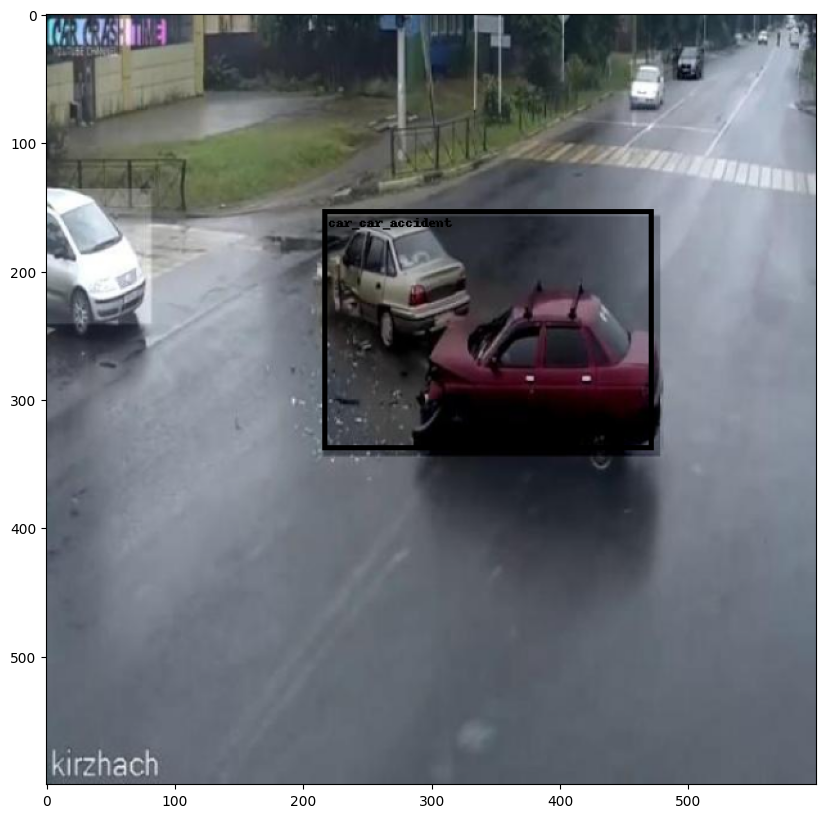

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))